%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

### red deer vocalizations
Source:
- http://www.tierstimmenarchiv.de/webinterface/contents/treebrowser.php

In [377]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import re
import IPython
import librosa
import librosa.display

In [378]:
from avgn.signalprocessing import spectrogramming as sg

In [379]:
import pdb
from joblib import Parallel, delayed
n_jobs = 10
verbosity = 5

### data locations

In [380]:
from glob import glob

In [381]:
DSLOC = Path('/mnt/cube/Datasets/animalsoundarchive/cervus_elaphus/')

In [382]:
fg_list = list(DSLOC.glob('*.mp3'))
len(fg_list), np.sort(fg_list)[-5:]

(88,
 array([ PosixPath('/mnt/cube/Datasets/animalsoundarchive/cervus_elaphus/Cervus_elaphus_S1408_14_short.mp3'),
        PosixPath('/mnt/cube/Datasets/animalsoundarchive/cervus_elaphus/Cervus_elaphus_S1408_17_short.mp3'),
        PosixPath('/mnt/cube/Datasets/animalsoundarchive/cervus_elaphus/Cervus_elaphus_V1277_11_short.mp3'),
        PosixPath('/mnt/cube/Datasets/animalsoundarchive/cervus_elaphus/Cervus_elaphus_V1277_13_short.mp3'),
        PosixPath('/mnt/cube/Datasets/animalsoundarchive/cervus_elaphus/Cervus_elaphus_V2125_13_short.mp3')], dtype=object))

In [383]:
vocalization_lib = pd.read_excel(DSLOC.parent / 'recording_df.xlsx')
voc_df = vocalization_lib[(vocalization_lib.species == 'Cervus elaphus')  & (vocalization_lib.author == 'Tembrock, Günter')]
voc_df = voc_df[['filename', 'species', 'filename_ext', 'description', 'duration', 'notes', 'unique_identifier', 'bytes', 'recording_type']]

In [384]:
voc_df[:3]

,filename,species,filename_ext,description,duration,notes,unique_identifier,bytes,recording_type
23,0025_Altai_Maral_Hirsch_Brunft,Cervus elaphus,0025_Altai_Maral_Hirsch_Brunft_short.mp3,Bruftrufe.,0:0:0,Mastered Recording - Original: B: S1026_03_Pos...,TSA:0025_Altai_Maral_Brunft,247000,s
159,0168_Bucharahirsch_Brunft,Cervus elaphus,0168_Bucharahirsch_Brunft_short.mp3,Brunftrufe.,0:0:0,Mastered Recording - Original: B: S1293_01_POS...,TSA:0168_Bucharahirsch_Brunft,277000,s
160,0169_Bucharahirsch_Brunft,Cervus elaphus,0169_Bucharahirsch_Brunft_short.mp3,Brunft.,0:0:0,Mastered Recording - Original: B: S1505_02_Pos...,TSA:0169_Bucharahirsch_Brunft,169000,s


In [385]:
names = [i.split('.')[0].split(':')[0].split(',')[0].split(' ')[0] for i in voc_df.description.values]
np.unique(names),len(np.unique(names))

(array(['Altai-Maral', 'Bruftrufe', 'Brunft', 'Brunft-Rufe', 'Brunftrufe',
        'Brunftschrei', 'Buchara-Hirsch', 'Bucharahirsch', 'Hirsch',
        'Isubra-Hirsch', 'Isubrahirsch', 'Rufe', 'Röhren', 'Unvollständige',
        'Wapiti', 'Weibliche', 'Weibliches', 'Zwergwapiti'],
       dtype='<U14'),
 18)

In [386]:
row = voc_df.iloc[5]

In [387]:
row

filename                             1481_Wapiti_Maennchen_Drohzischen
species                                                 Cervus elaphus
filename_ext               1481_Wapiti_Maennchen_Drohzischen_short.mp3
description                       Wapiti: Drohzischen eines Männchens.
duration                                                         0:0:0
notes                Mastered Recording - Original: B: S1279_02_Pos...
unique_identifier                TSA:1481_Wapiti_Maennchen_Drohzischen
bytes                                                           262000
recording_type                                                       s
Name: 1460, dtype: object

In [388]:
mp3_path = np.array(fg_list)[row.filename_ext == np.array([i.name for i in fg_list])][0]

In [389]:
y, sr = librosa.load(mp3_path.as_posix())
y = y[30000:140000]

/home/AD/tsainbur/anaconda3/envs/neuroethology/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [390]:
len(y)/sr

4.988662131519274

In [391]:
sr

22050

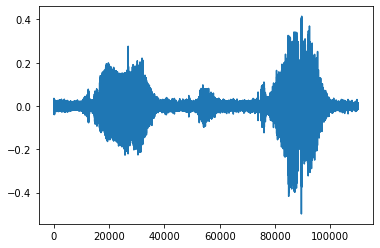

In [392]:
plt.plot(y)

In [393]:
D = np.abs(librosa.stft(y))**2
S_dB = librosa.power_to_db(D, ref=np.max)

In [394]:
spec = S_dB

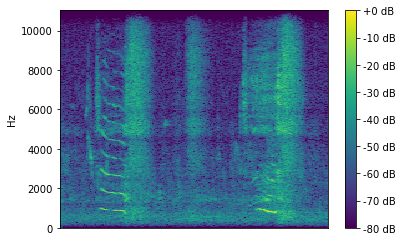

In [395]:
fig, ax = plt.subplots()
img = librosa.display.specshow(spec, cmap='viridis', y_axis='linear', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')

[Text(0.5, 1.0, 'Spectrogram')]

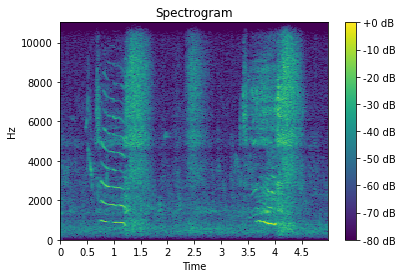

In [396]:
fig, ax = plt.subplots()
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='linear', sr=sr,
                         fmax=8000, ax=ax, cmap = 'viridis')
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Spectrogram')

### Low frequency res

In [465]:
D_512 = D = np.abs(librosa.stft(y, n_fft=64))**2
S_dB = librosa.power_to_db(D_512, ref=np.max)

In [466]:
spec_high_temp_res = S_dB
spec_high_temp_res.shape

(33, 6876)

(array([  6165.,   7817.,  21773.,  40922.,  41857.,  44741.,  38247.,
         19019.,   5607.,    760.]),
 array([ -8.00000000e+01,  -7.20000000e+01,  -6.40000000e+01,
         -5.60000000e+01,  -4.80000000e+01,  -4.00000000e+01,
         -3.20000000e+01,  -2.40000000e+01,  -1.60000000e+01,
         -8.00000095e+00,  -9.53674316e-07], dtype=float32),
 <BarContainer object of 10 artists>)

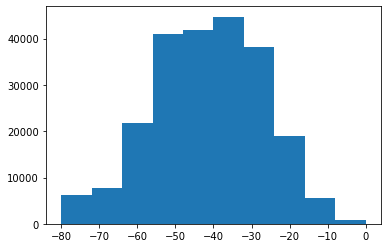

In [468]:
plt.hist(spec_high_temp_res.flatten())

[Text(0.5, 1.0, 'Spectrogram')]

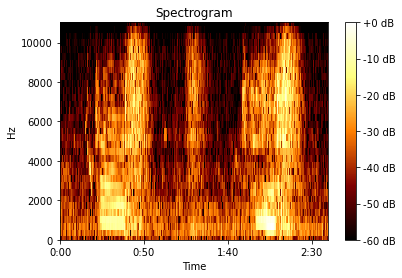

In [476]:
fig, ax = plt.subplots()
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='linear', sr=sr,
                         fmax=8000, ax=ax, cmap = 'afmhot', vmin = 0, vmax = -60)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Spectrogram')

### Low temporal res

In [400]:
D_512 = D = np.abs(librosa.stft(y, n_fft=1024*8))**2
S_dB = librosa.power_to_db(D_512, ref=np.max)

In [401]:
spec_high_freq_res = S_dB
spec_high_freq_res.shape

(4097, 54)

[Text(0.5, 1.0, 'Spectrogram')]

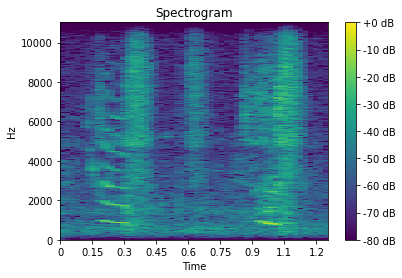

In [402]:
fig, ax = plt.subplots()
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='linear', sr=sr,
                         fmax=8000, ax=ax, cmap = 'viridis')
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Spectrogram')

### Mel spec

In [403]:
D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

In [404]:
melspec = S_dB

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

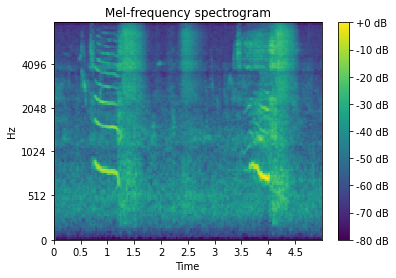

In [405]:
fig, ax = plt.subplots()
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax, cmap = 'viridis')
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

### MFCCs

In [406]:
### create a divergent CMAP equivalent to afmhot

In [407]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import copy

In [408]:
afm_hot = cm.get_cmap('afmhot', 10)
bone  = cm.get_cmap('bone', 10)
blues  = cm.get_cmap('Blues', 10)

In [409]:
np.logspace(-10,0, 10)

array([  1.00000000e-10,   1.29154967e-09,   1.66810054e-08,
         2.15443469e-07,   2.78255940e-06,   3.59381366e-05,
         4.64158883e-04,   5.99484250e-03,   7.74263683e-02,
         1.00000000e+00])

In [410]:
afmhot_blues = np.vstack([afm_hot(np.linspace(0,1, 10))[::-1], blues(np.linspace(0,1, 10))[::-1]])#[::-1]

In [411]:
afmhot_blues_cmap = LinearSegmentedColormap.from_list('afmhot_blues', afmhot_blues)

In [412]:
import seaborn as sns

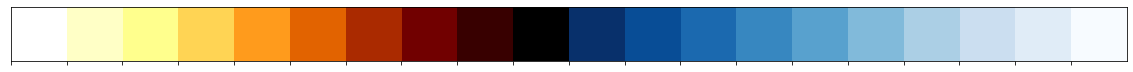

In [413]:
sns.palplot(afmhot_blues)

In [414]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

[Text(0.5, 1.0, 'MFCC')]

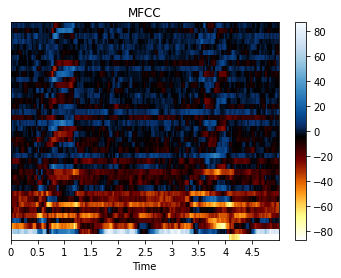

In [415]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax, cmap = afmhot_blues_cmap, vmin=-np.abs(np.max(mfccs)),
    vmax=np.abs(np.max(mfccs)),)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

### PCEN

In [416]:
S = np.abs(librosa.stft(y))
log_S = librosa.amplitude_to_db(S, ref=np.max)
pcen_S = librosa.pcen(S)

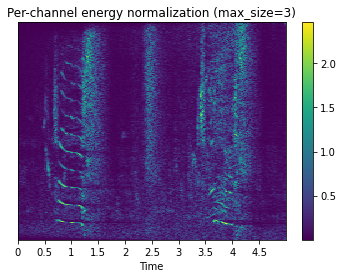

In [417]:
fig, ax = plt.subplots()
img = librosa.display.specshow(pcen_S, x_axis='time', ax=ax, cmap = 'viridis')
ax.set(title='Per-channel energy normalization (max_size=3)')
fig.colorbar(img, ax=ax)

### Reduced noise

In [418]:
import noisereduce as nr

In [419]:
y_nr = nr.reduce_noise(y, sr=sr, n_std_thresh_stationary = 1, prop_decrease=0.95, stationary=True)

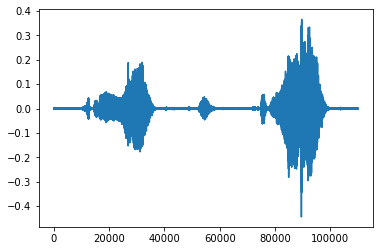

In [420]:
plt.plot(y_nr)

In [421]:
D = np.abs(librosa.stft(y_nr))**2
S_dB = librosa.power_to_db(D, ref=np.max)


In [422]:
spec_noisereduce = S_dB

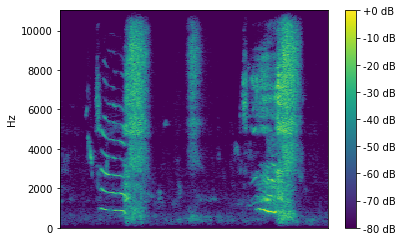

In [423]:
fig, ax = plt.subplots()
img = librosa.display.specshow(S_dB, cmap='viridis', y_axis='linear', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')

### Superlet

In [424]:
from scipy.signal import fftconvolve
np.asnumpy = np.asarray

In [425]:
cp = np

In [426]:
# from https://gist.github.com/EtienneCmb/f76d8b4aba0088aba6a8c07e397a33c2
def bw_cf(t, bw, cf):
    """Computes the complex wavelet coefficients for the desired time point t,
    bandwidth bw and center frequency cf"""
    cnorm = 1 / (bw * np.sqrt(2 * np.pi))
    exp1 = cnorm * np.exp(-(t ** 2) / (2 * (bw ** 2)));
    res = np.exp(2j * np.pi * cf * t) * exp1
    return res


def gauss(t, sd):
    """Compute the gaussian coefficient for the desired time point t and
    standard deviation sd"""
    cnorm = 1 / (sd * np.sqrt(2 * np.pi))
    res = cnorm * np.exp(-(t ** 2) / (2 * (sd ** 2)))
    return res


def cxmorlet(fc, n_cycles, sfreq):
    """Computes the complex Morlet wavelet for the desired center frequency.
    
    Parameters
    ----------
    fc : center frequency
    n_cycles : number of cycles
    sfreq : sampling frequency
    """
    # we want to have the last peak at 2.5 SD
    sd = (n_cycles / 2) * (1 / fc) / 2.5
    wl = int(2 * np.floor(np.fix(6 * sd * sfreq) / 2) + 1)
    w = np.zeros((wl), dtype=np.complex128)
    gi = 0
    off = np.fix(wl / 2)
    for i in range(wl):
        t = (i - off) / sfreq
        w[i] = bw_cf(t, sd, fc)
        gi += gauss(t, sd)
    w /= gi
    return w


def aslt(data, sfreq, foi, n_cycles, order=None, mult=False):
    """Adaptive superresolution wavelet (superlet) transform.
    
    - data (array_like) : (n_epochs, n_times)
    - sfreq (float) : sampling frequency
    - foi (array_like) : central frequency of interest
    - n_cycles (integer) : number of initial wavelet cycles
    - order (array_like) : interval of super-resolution orders of shape (2,).
      For example, use order=[1, 30]
    - mult (bool) : specifies the use of multiplicative super-resolution (True)
      or additive (False)
    """
    # inputs checking
    assert isinstance(data, np.ndarray)
    data = np.atleast_2d(data).astype(np.float32)
    n_epochs, n_times = data.shape
    foi = np.asarray(foi)
    n_freqs = len(foi)

    # check order parameter and initialize the order used at each frequency. If
    # empty, go with an order of 1 for each frequency (single wavelet per set)
    if order is not None:
        order_ls = np.fix(np.linspace(order[0], order[1], n_freqs)).astype(int)
    else:
        order_ls = np.ones((n_freqs,), dtype=np.int)
        
    # the padding will be size of the lateral zero-pads, which serve to avoid
    # border effects during convolution
    padding = 0
    
    # the wavelet sets
    wavelets = dict()
    
    # initialize wavelet sets for either additive or multiplicative
    # superresolution
    for i_freq in tqdm(range(n_freqs), desc='n_freqs'):
        for i_ord in range(order_ls[i_freq]):
            # get the number of cycles
            if mult:  # multiplicative superresolution
                n_cyc = n_cycles * (i_ord + 1)
            else:     # additive superresolution
                n_cyc = n_cycles + i_ord
            
            # each new wavelet has n_cyc extra cycles
            _w = cxmorlet(foi[i_freq], n_cyc, sfreq)
            
            # the margin will be the half-size of the largest wavelet
            padding = max(padding, np.fix(len(_w) / 2))
            
            wavelets[(i_freq, i_ord)] = _w
    
    # the zero-padded buffer
    buffer = cp.zeros((n_epochs, int(n_times + 2 * padding)),
                      dtype=cp.float32)

    # convenience indexers for the zero-padded buffer
    bufbegin = int(padding)
    bufend = int(padding + n_times)
    
    # fill the central part of the buffer with input data
    buffer[:, bufbegin:bufend] = cp.asarray(data)
    
    # the output scalogram
    wtresult = cp.zeros((n_epochs, n_freqs, n_times), dtype=cp.float32)

    for i_freq in tqdm(range(n_freqs), desc='n_freqs'):
        # pooling buffer, starts with 1 because we're doing geometric mean
        temp = cp.ones((n_epochs, n_times), dtype=cp.float32)

        # compute the convolution of the buffer with each wavelet in the
        # current set
        for i_ord in range(order_ls[i_freq]):
            # get the single wavelets
            sw = cp.asarray(wavelets[(i_freq, i_ord)]).reshape(1, -1)
    
            # restricted convolution (input size == output size)
            _temp = fftconvolve(buffer, sw, mode='same', axes=1)

            # accumulate the magnitude (times 2 to get the full spectral
            # energy
            temp *= (2 * cp.abs(_temp[:, bufbegin:bufend]))

        # compute the power of the geometric mean
        root = 1. / float(order_ls[i_freq])
        temp = (temp ** root) ** 2

        # accumulate the current FOI to the result spectrum
        wtresult[:, i_freq, :] += temp
    
    return cp.asnumpy(wtresult)

In [427]:
#- data (array_like) : (n_epochs, n_times)
#- sfreq (float) : sampling frequency
#- foi (array_like) : central frequency of interest
#- n_cycles (integer) : number of initial wavelet cycles
#- order (array_like) : interval of super-resolution orders of shape (2,).
#  For example, use order=[1, 30]
#- mult (bool) : specifies the use of multiplicative super-resolution (True)
#  or additive (False)

In [428]:
np.log(500)/np.log(10)

2.6989700043360183

In [429]:
#foi = np.logspace(np.log(500)/np.log(10), np.log(12000)/np.log(10), 100, base=10)
foi = np.linspace(10, sr/2, 256)

In [430]:
n_cycles = 100
order = [1, 30]
foi.shape

(256,)

In [431]:
superlet = aslt(y, sr, foi= foi, n_cycles=n_cycles, order=None, mult=False)

/home/AD/tsainbur/anaconda3/envs/neuroethology/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


n_freqs:   0%|          | 0/256 [00:00<?, ?it/s]

n_freqs:   0%|          | 0/256 [00:00<?, ?it/s]

In [432]:
superlet.shape

(1, 256, 110000)

In [433]:
log_superlet = np.log10(superlet[0]**2)

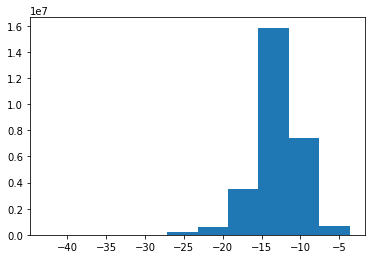

In [434]:
plt.hist(log_superlet.flatten());

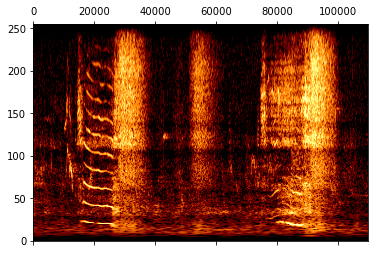

In [435]:
fig, ax = plt.subplots()
ax.matshow(log_superlet, aspect="auto", interpolation=None, origin="lower", cmap=plt.cm.afmhot, vmin = -15)

### Wavelet

In [436]:
# from https://github.com/obspy/obspy/blob/master/obspy/signal/tf_misfit.py
from obspy.imaging.cm import obspy_sequential, obspy_divergent
from obspy.signal import util


def cwt(st, dt, w0, fmin, fmax, nf=100, wl='morlet'):
    """
    Continuous Wavelet Transformation in the Frequency Domain.
    .. seealso:: [Kristekova2006]_, eq. (4)
    :param st: time dependent signal.
    :param dt: time step between two samples in st (in seconds)
    :param w0: parameter for the wavelet, tradeoff between time and frequency
        resolution
    :param fmin: minimum frequency (in Hz)
    :param fmax: maximum frequency (in Hz)
    :param nf: number of logarithmically spaced frequencies between fmin and
        fmax
    :param wl: wavelet to use, for now only 'morlet' is implemented
    :return: time frequency representation of st, type numpy.ndarray of complex
        values, shape = (nf, len(st)).
    """
    npts = len(st) * 2
    tmax = (npts - 1) * dt
    t = np.linspace(0., tmax, npts)
    #f = np.logspace(np.log10(fmin), np.log10(fmax), nf)
    f = np.linspace(fmin, fmax, nf)

    cwt = np.zeros((npts // 2, nf), dtype=np.complex)

    if wl == 'morlet':

        def psi(t):
            return np.pi ** (-.25) * np.exp(1j * w0 * t) * \
                np.exp(-t ** 2 / 2.)

        def scale(f):
            return w0 / (2 * np.pi * f)
    else:
        raise ValueError('wavelet type "' + wl + '" not defined!')

    nfft = util.next_pow_2(npts) * 2
    sf = np.fft.fft(st, n=nfft)

    # Ignore underflows.
    with np.errstate(under="ignore"):
        for n, _f in enumerate(tqdm(f)):
            a = scale(_f)
            # time shift necessary, because wavelet is defined around t = 0
            psih = psi(-1 * (t - t[-1] / 2.) / a).conjugate() / np.abs(a) ** .5
            psihf = np.fft.fft(psih, n=nfft)
            tminin = int(t[-1] / 2. / (t[1] - t[0]))
            cwt[:, n] = np.fft.ifft(psihf * sf)[tminin:tminin + npts // 2] * \
                (t[1] - t[0])

    return cwt.T


In [ ]:
fmin = 500
fmax = 11025
w0 = 50

In [437]:
scalogram = np.abs(cwt(st=y, dt=1/sr, w0=w0, fmin=10, fmax = sr/2, nf=256, wl='morlet'))

/home/AD/tsainbur/anaconda3/envs/neuroethology/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  0%|          | 0/256 [00:00<?, ?it/s]

In [438]:
log_scalogram = np.log10(np.abs(scalogram)**2)

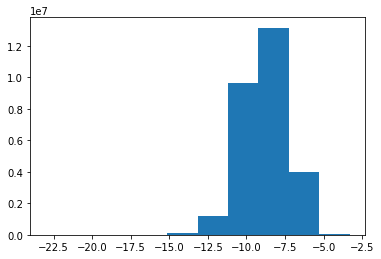

In [439]:
plt.hist(log_scalogram.flatten());

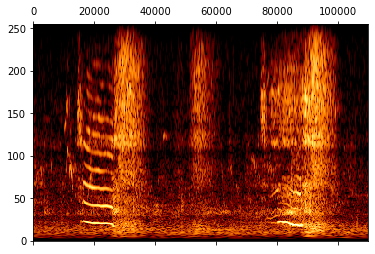

In [440]:
fig, ax = plt.subplots()
ax.matshow(log_scalogram, aspect='auto', origin='lower', vmin = -10, cmap = plt.cm.afmhot)
plt.show() # d

### Time frequency

In [441]:
import libtfr

In [442]:
"""
s - input signal (real)
N - number of frequency points
step - step size (in time points)
Np - window size (should be <= N)
K - number of tapers to use (default 6)
tm - time support of tapers (default 6.0)
flock - frequency locking parameter; power is not reassigned
        more than this value (normalized frequency; default 0.01)
tlock - time locking parameter (in frames; default 5)
fgrid - output frequency bins: monotonically increasing
        (default linear scale with N points; Nyquist is 1.0)

returns an N/2+1 by L power spectrogram, or if fgrid is specified,
fgrid.size by L
"""
nfft = 1024
Np = nfft
shift = nfft/16
K = 6
tm = 6.0
flock = 0.01
tlock = 5*2

In [443]:
from tqdm.autonotebook import tqdm

In [444]:
np.max(S) == np.inf

False

In [449]:
for i in tqdm(range(1000)):
    S = np.abs(libtfr.tfr_spec(s=y, N=nfft, step=shift, Np=Np, K=K, tm=tm, flock=flock, tlock=tlock))
    
    if np.max(S) != np.inf:
        break
    break
print(np.shape(S), np.max(S), np.min(S))

  0%|          | 0/1000 [00:00<?, ?it/s]

(513, 1703) 86.7294463912 0.0


In [450]:
S = librosa.power_to_db(S, ref=np.max)
print(np.shape(S), np.max(S), np.min(S))

(513, 1703) 0.0 -80.0


In [451]:
S_tfr = S

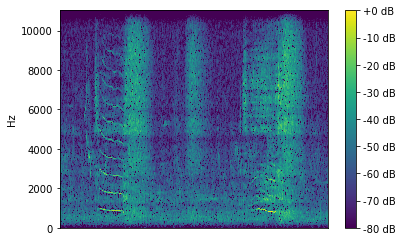

In [452]:
fig, ax = plt.subplots()
img = librosa.display.specshow(S, cmap='viridis', y_axis='linear', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')

In [453]:
# spec, spec_high_temp_res, spec_high_freq_res, melspec, mfccs, pcen_S, spec_noisereduce, S_tfr

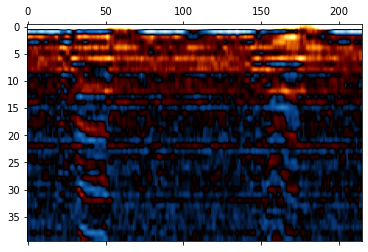

In [454]:
fig, ax = plt.subplots()
vmax = np.abs(np.max(mfccs))*1
ax.matshow(mfccs, aspect='auto', interpolation=None, cmap=afmhot_blues_cmap, vmin=-vmax, vmax=vmax)

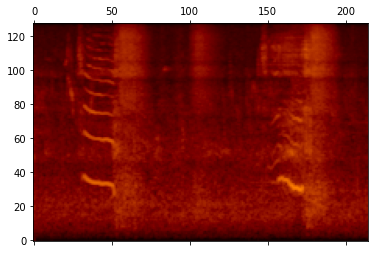

In [455]:
fig, ax = plt.subplots()
ax.matshow(melspec, aspect='auto', interpolation=None, origin='lower', cmap=plt.cm.afmhot, vmin=-vmax, vmax=vmax)

In [456]:
characters = 'ABCDEFGHIJKLMNOPQURSTUVWXYZ'

In [457]:
def set_title(ax, title):
    ax.text(
        0.5,
        0.95,
        title,
        horizontalalignment="center",
        verticalalignment="top",
        fontweight="bold",
        color="white",
        fontsize=14,
        transform=ax.transAxes,
    )

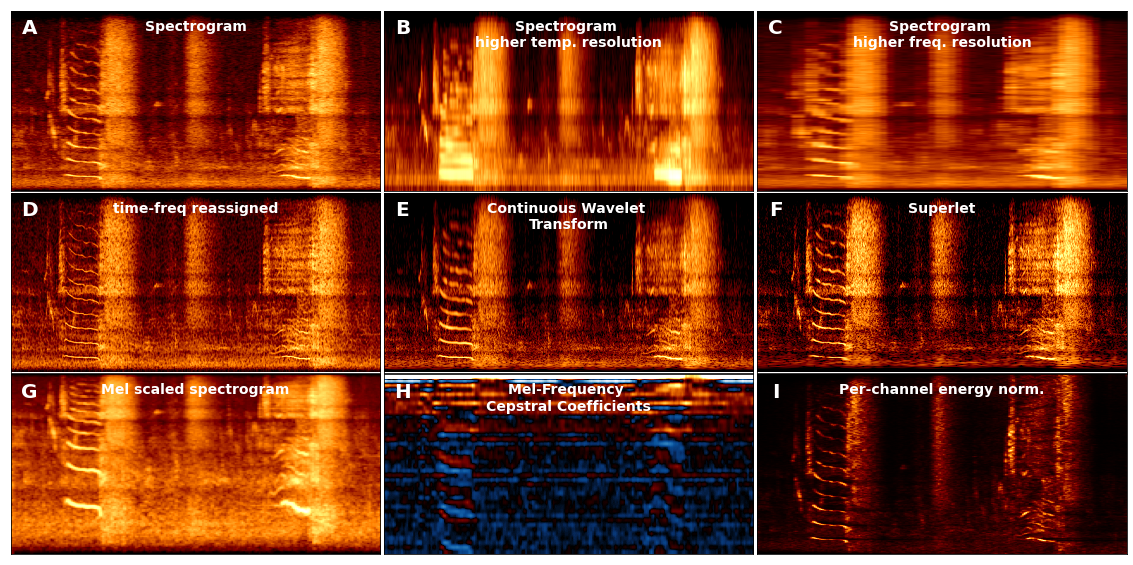

In [481]:
cmap = plt.cm.afmhot
fontsize = 18
fig, axs = plt.subplots(
    ncols=3, nrows=3, figsize=(20, 10), gridspec_kw={"wspace": 0.01, "hspace": 0.01}
)
ax = axs[0, 0]
ax.matshow(spec, aspect="auto", interpolation=None, origin="lower", cmap=cmap)
set_title(ax, "Spectrogram")

ax = axs[0, 1]
ax.matshow(
    spec_high_temp_res, aspect="auto", interpolation=None, origin="lower", cmap=cmap, vmin = -60
)
set_title(ax,"Spectrogram \nhigher temp. resolution")

ax = axs[0, 2]
ax.matshow(
    spec_high_freq_res, aspect="auto", interpolation=None, origin="lower", cmap=cmap
)
set_title(ax, "Spectrogram \nhigher freq. resolution")

ax = axs[1, 0]
ax.matshow(S_tfr, aspect="auto", interpolation=None, origin="lower", cmap=cmap)
set_title(ax, "time-freq reassigned")

ax = axs[1, 1]
ax.matshow(
    log_scalogram, aspect="auto",  interpolation=None, origin="lower", cmap=cmap, vmin = -10
)
set_title(ax, "Continuous Wavelet \nTransform")

ax = axs[1, 2]
ax.matshow(
    log_superlet, aspect="auto", interpolation=None, origin="lower", cmap=cmap, vmin = -15
)
set_title(ax, "Superlet")

ax = axs[2, 0]
ax.matshow(melspec, aspect="auto", interpolation=None, origin="lower", cmap=cmap)
set_title(ax, "Mel scaled spectrogram")

ax = axs[2, 1]
ax.matshow(
    mfccs,
    aspect="auto",
    interpolation=None,
    #origin="lower",
    cmap=afmhot_blues_cmap,
    vmin=-np.abs(np.max(mfccs)),
    vmax=np.abs(np.max(mfccs)),
)
set_title(ax, "Mel-Frequency \nCepstral Coefficients")

ax = axs[2, 2]
ax.matshow(pcen_S, aspect="auto", interpolation=None, origin="lower", cmap=cmap)
set_title(ax, "Per-channel energy norm.")



for axi, ax in enumerate(axs.flatten()):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(
        0.05,
        0.9,
        characters[axi],
        fontweight="bold",
        color="white",
        fontsize=20,
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
    )

In [ ]:
breakme

### scalogram

In [215]:
import obspy
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt

In [216]:
fmin = 500
fmax = 11025
w0 = 50

In [239]:
??cwt

In [217]:
scalogram = np.abs(cwt(st=y, dt=1/sr, w0=w0, fmin=fmin, fmax = fmax, wl='morlet'))

In [218]:
scalogram.shape

(100, 110000)

In [219]:
log_scalogram = 20*np.log10(np.abs(scalogram)**2)

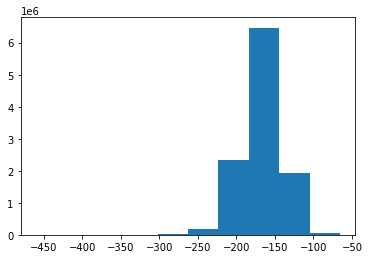

In [223]:
plt.hist(log_scalogram.flatten());

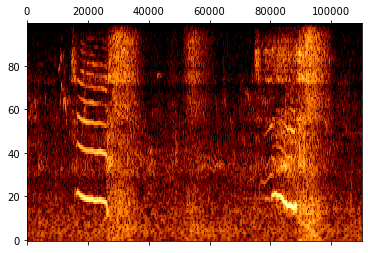

In [227]:
fig, ax = plt.subplots()
ax.matshow(log_scalogram, aspect='auto', origin='lower', vmax = -50, vmin = -200, cmap = plt.cm.afmhot)
plt.show() # d

In [212]:
t = np.linspace(0, 1/sr * len(y), len(y))
x0, y0 = np.meshgrid(
    t,
    np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))

In [213]:
x.shape, y.shape, t.shape

((100, 100), (110000,), (110000,))

/home/AD/tsainbur/anaconda3/envs/neuroethology/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


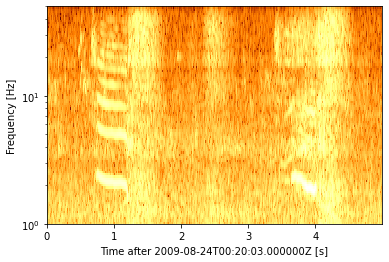

In [214]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.pcolormesh(x0, y0, log_scalogram, cmap=plt.cm.afmhot)
ax.set_xlabel("Time after %s [s]" % tr.stats.starttime)
ax.set_ylabel("Frequency [Hz]")
ax.set_yscale('log')
ax.set_ylim(f_min, f_max)
plt.show()